In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


In [265]:
regression_df = pd.read_csv("regression_df_official.csv")

# **data**

In [266]:
regression_df

,date,package_count,day_of_week,is_friday,is_holiday,is_after_holiday,is_manual_closure,is_closed_day,is_post_event_window,is_open_day,...,weekofyear,n_active_china_routes,dominant_country,china_rolling7_std,is_promo_day,days_since_promo,total_china_rerouted,is_big_jump,is_outlier,is_iqr_outlier
0,2022-01-03,1,0,0,0,0,0,0,0,1,...,1,0,SG,0.000000,0,NaN,0,0,0,0
1,2022-01-04,8,1,0,0,0,0,0,0,1,...,1,0,SG,0.000000,0,NaN,0,1,0,0
2,2022-01-05,186,2,0,0,0,0,0,0,1,...,1,0,SG,99.881597,0,NaN,173,1,0,0
3,2022-01-06,807,3,0,0,0,0,0,0,1,...,1,0,SG,366.846471,0,NaN,773,0,0,0
4,2022-01-08,595,5,0,0,0,0,0,0,1,...,1,0,SG,349.088384,0,NaN,560,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2025-05-17,30,5,0,0,0,0,0,0,1,...,20,2,CN,2454.052421,0,156.0,2,0,0,0
1019,2025-05-18,6,6,0,0,0,0,0,0,1,...,20,0,SG,965.145708,0,157.0,0,0,0,0
1020,2025-05-19,37,0,0,0,0,0,0,0,1,...,21,0,AE,20.123429,0,158.0,1,1,0,0
1021,2025-05-20,20,1,0,0,0,0,0,0,1,...,21,0,AE,1.914854,0,159.0,2,0,0,0


# **ommiting missing values**

In [267]:
data = regression_df
data = data[['date', 'package_count']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.set_index('date', inplace=True)
display(data)

,date,package_count
0,2022-01-03,1
1,2022-01-04,8
2,2022-01-05,186
3,2022-01-06,807
4,2022-01-08,595
...,...,...
1018,2025-05-17,30
1019,2025-05-18,6
1020,2025-05-19,37
1021,2025-05-20,20


In [268]:
data['lag_1_week'] = data['package_count'].shift(6)
data['rolling_week_avg'] = data['package_count'].rolling(window=6).mean()
data = data.dropna()
display(data)

,date,package_count,lag_1_week,rolling_week_avg
6,2022-01-10,2016,1.0,985.666667
7,2022-01-11,97,8.0,1000.500000
8,2022-01-13,2105,186.0,1320.333333
9,2022-01-15,6313,807.0,2238.000000
10,2022-01-16,613,595.0,2241.000000
...,...,...,...,...
1018,2025-05-17,30,6788.0,487.166667
1019,2025-05-18,6,2694.0,39.166667
1020,2025-05-19,37,86.0,31.000000
1021,2025-05-20,20,48.0,26.333333


In [269]:
data[[ 'package_count']]

,package_count
6,2016
7,97
8,2105
9,6313
10,613
...,...
1018,30
1019,6
1020,37
1021,20


In [270]:
data[['package_count', 'rolling_week_avg']]

,package_count,rolling_week_avg
6,2016,985.666667
7,97,1000.500000
8,2105,1320.333333
9,6313,2238.000000
10,613,2241.000000
...,...,...
1018,30,487.166667
1019,6,39.166667
1020,37,31.000000
1021,20,26.333333


## prediction of average rolling 

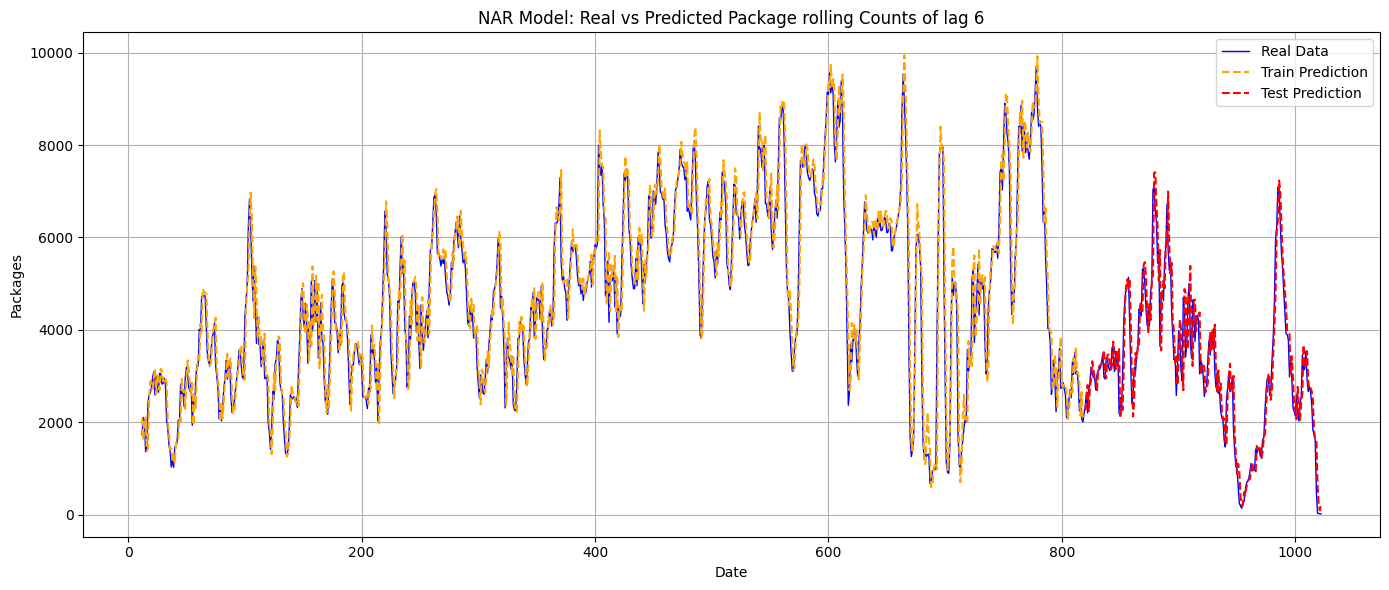

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----- Step 1: Define function to create lag features -----
def create_lagged_features(series, lag=6):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# ----- Step 2: Load your data -----
# Assume 'data' is a pandas Series or a column in a DataFrame
# If it's a DataFrame with column 'packages', use: series = data['packages']
series = data['rolling_week_avg'].values.flatten()  # Convert to 1D numpy array if needed

# ----- Step 3: Create lagged features -----
lag = 6
X, y = create_lagged_features(series, lag=lag)

# ----- Step 4: Split into train and test -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----- Step 5: Train NAR (MLP Regressor) -----
model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# ----- Step 6: Make predictions -----
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ----- Step 7: Reconstruct time index for plotting -----
# Build a timeline to align predictions with original series
time_index = data.index
full_index = time_index[lag:]  # Drop first lag rows
train_index = full_index[:len(y_train)]
test_index = full_index[len(y_train):]

# ----- Step 8: Plot -----
plt.figure(figsize=(14, 6))

# Real values
plt.plot(full_index, y, label='Real Data', color='blue', linewidth=1)

# Predictions
plt.plot(train_index, y_train_pred, label='Train Prediction', color='orange', linestyle='--')
plt.plot(test_index, y_test_pred, label='Test Prediction', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Packages')
plt.title('NAR Model: Real vs Predicted Package rolling Counts of lag 6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [272]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Test metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("🔵 Train Metrics:")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"R²:   {r2_train:.3f}")

print("\n🔴 Test Metrics:")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.3f}")


🔵 Train Metrics:
MAE:  459.41
MSE:  380155.84
RMSE: 616.57
R²:   0.900

🔴 Test Metrics:
MAE:  417.86
MSE:  320526.00
RMSE: 566.15
R²:   0.862


# **predicting the data sith the same method**

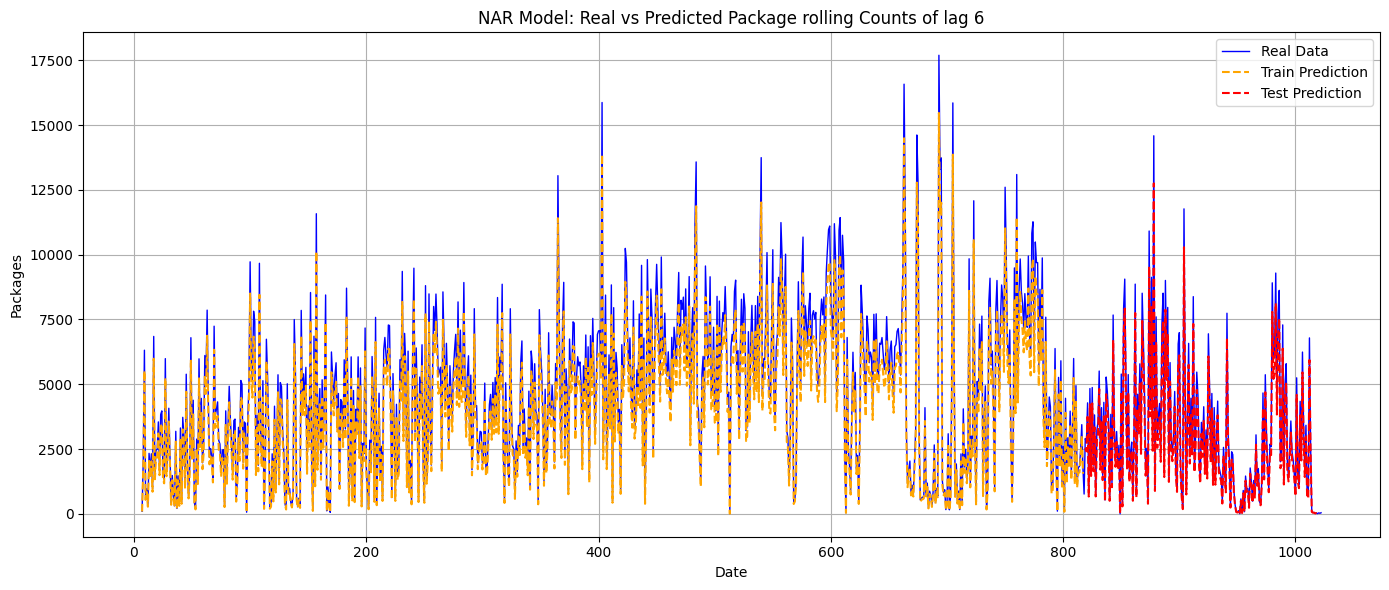

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----- Step 1: Define function to create lag features -----
def create_lagged_features(series, lag=6):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# ----- Step 2: Load your data -----
# Assume 'data' is a pandas Series or a column in a DataFrame
# If it's a DataFrame with column 'packages', use: series = data['packages']
series = data['package_count'].values.flatten()  # Convert to 1D numpy array if needed

# ----- Step 3: Create lagged features -----
lag = 1
X, y = create_lagged_features(series, lag=lag)

# ----- Step 4: Split into train and test -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----- Step 5: Train NAR (MLP Regressor) -----
model = MLPRegressor(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# ----- Step 6: Make predictions -----
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ----- Step 7: Reconstruct time index for plotting -----
# Build a timeline to align predictions with original series
time_index = data.index
full_index = time_index[lag:]  # Drop first lag rows
train_index = full_index[:len(y_train)]
test_index = full_index[len(y_train):]

# ----- Step 8: Plot -----
plt.figure(figsize=(14, 6))

# Real values
plt.plot(full_index, y, label='Real Data', color='blue', linewidth=1)

# Predictions
plt.plot(train_index[:len(train_index)-1], y_train_pred[1:], label='Train Prediction', color='orange', linestyle='--')
plt.plot(test_index[:len(test_index)-1], y_test_pred[1:], label='Test Prediction', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Packages')
plt.title('NAR Model: Real vs Predicted Package rolling Counts of lag 6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [274]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train metrics
mae_train = mean_absolute_error(y_train[:len(y_train)-1], y_train_pred[1:])
mse_train = mean_squared_error(y_train[:len(y_train)-1], y_train_pred[1:])
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train[:len(y_train)-1], y_train_pred[1:])

# Test metrics
mae_test = mean_absolute_error(y_test[:len(y_test)-1], y_test_pred[1:])
mse_test = mean_squared_error(y_test[:len(y_test)-1], y_test_pred[1:])
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test[:len(y_test)-1], y_test_pred[1:])

print("🔵 Train Metrics:")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"R²:   {r2_train:.3f}")

print("\n🔴 Test Metrics:")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.3f}")


🔵 Train Metrics:
MAE:  601.96
MSE:  508474.24
RMSE: 713.07
R²:   0.945

🔴 Test Metrics:
MAE:  400.73
MSE:  272323.96
RMSE: 521.85
R²:   0.961
